In [1]:
import pandas as pd
import numpy as np
import random
from rdkit import Chem
from csnn_model import CSNNet, device, batch_size, test_csnn , train_csnn
from snn_model import get_loss_fn, compute_loss
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from utils import load_dataset_df, fp_generator
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score

#### Load DataFrame

In [2]:
files = ['tox21.csv','sider.csv', 'BBBP.csv']
dt_file = files[2]

df, targets = load_dataset_df(filename=dt_file)
print(targets)

target_name = targets[0]
df = df[[target_name, 'smiles']].dropna()


['p_np']


#### SMILE to Fingerprint

In [3]:
fp_types = [['morgan', 1024], ['maccs', 167], ['RDKit', 1024]]
fp_type, num_bits = fp_types[0]
print(fp_type, '-', num_bits)
num_rows = len(df)
fp_array = np.zeros((num_rows, num_bits))
target_array = np.zeros((num_rows, 1))
i = 0

img = None
# Smile to Fingerprint of size {num_bits}
fp_gen = fp_generator(fp_type)
for idx, row in df.iterrows():
    mol = Chem.MolFromSmiles(row['smiles'])
    #TODO: sanitize molecules to remove the warnings (?)
    
    if mol is not None:
        fingerprint = fp_gen(mol)

        fp_array[i] = np.array(fingerprint)
        target_array[i] = row[target_name]
        i += 1
target_array = target_array.ravel()

morgan - 1024


[16:37:14] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:37:14] WARNING: not removing hydrogen atom without neighbors
[16:37:14] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:37:14] WARNING: not removing hydrogen atom without neighbors
[16:37:14] WARNING: not removing hydrogen atom without neighbors
[16:37:14] WARNING: not removing hydrogen atom without neighbors
[16:37:14] WARNING: not removing hydrogen atom without neighbors
[16:37:14] WARNING: not removing hydrogen atom without neighbors
[16:37:14] WARNING: not removing hydrogen atom without neighbors
[16:37:14] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:37:14] WARNING: not removing hydrogen atom without neighbors
[16:37:14] WARNING: not removing hydrogen atom without neighbors
[16:37:14] WARNING: not removing hydrogen atom without neighbors
[16:37:15] WARNING: not removing hydrogen atom without neighbors
[16:37:15] Explicit valence for atom # 11 N, 4, is greater than pe

In [4]:
# Create Torch Dataset
dtype = torch.float32
fp_tensor = torch.tensor(fp_array, dtype=dtype)
target_tensor = torch.tensor(target_array, dtype=dtype).long()

dataset = TensorDataset(fp_tensor, target_tensor)

#### Loss Function

In [5]:
from sklearn.utils.class_weight import compute_class_weight

loss_types = ['cross_entropy', 'rate_loss', 'temporal_loss']
loss_type = loss_types[0]
print(loss_type)

use_weights = True


cross_entropy


#### Train Loop

In [6]:
num_epochs = 200 #aumentar e diminuir lr
lr=1e-5 #default was e5-5
iterations = 5
time_steps = 10

In [7]:
"""def train_csnn(net, optimizer, device, num_epochs, train_loader, val_loader, loss_type, loss_fn, dtype):
    loss_hist = []

    for epoch in range(num_epochs):
        net.train()
        #print(f"Epoch:{epoch}")
        #train_batch = iter(train_loader)

        # Minibatch training loop
        for data, targets in train_loader:
            data = data.to(device).unsqueeze(1)
            targets = targets.to(device)
            #print(data.size(), data.view(batch_size, -1).size())
            #print(data.shape)
            if data.shape[0] < 32:
                continue
            # forward pass
            net.train()
            spk_rec, mem_rec = net(data)
            #print(spk_rec, mem_rec)
            #print(spk_rec.size(), mem_rec.size(), targets.size())
            # Compute loss
            loss_val = compute_loss(loss_type, loss_fn, spk_rec, mem_rec, targets, dtype) 
            #print(loss_val.item())

            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())



    return net, loss_hist
    """

'def train_csnn(net, optimizer, device, num_epochs, train_loader, val_loader, loss_type, loss_fn, dtype):\n    loss_hist = []\n\n    for epoch in range(num_epochs):\n        net.train()\n        #print(f"Epoch:{epoch}")\n        #train_batch = iter(train_loader)\n\n        # Minibatch training loop\n        for data, targets in train_loader:\n            data = data.to(device).unsqueeze(1)\n            targets = targets.to(device)\n            #print(data.size(), data.view(batch_size, -1).size())\n            #print(data.shape)\n            if data.shape[0] < 32:\n                continue\n            # forward pass\n            net.train()\n            spk_rec, mem_rec = net(data)\n            #print(spk_rec, mem_rec)\n            #print(spk_rec.size(), mem_rec.size(), targets.size())\n            # Compute loss\n            loss_val = compute_loss(loss_type, loss_fn, spk_rec, mem_rec, targets, dtype) \n            #print(loss_val.item())\n\n            # Gradient calculation + weight

In [8]:
net = CSNNet(input_size=num_bits, num_steps=10, spike_grad=None).to(device)
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of trainable parameters CSNN: {num_params}")

Number of trainable parameters CSNN: 32834


In [9]:
results = [[], [], [], [], [], []]
for iter in range(iterations):
    print(f"Iteration:{iter + 1}/{iterations}")
    random.seed(iter)

    spike_grad=None
    net = CSNNet(input_size=num_bits, num_steps=time_steps, spike_grad=spike_grad).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0)

    generator = torch.Generator().manual_seed(iter + 1)
    train, val, test = random_split(dataset, [0.8, 0.1, 0.1], generator=generator)

    _, train_label = train[:]
    _, val_label = val[:]
    _, test_label = test[:]

    # Load the Data
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)

    #Loss Function
    if use_weights:
        class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=np.array(train_label))
        class_weights = torch.tensor(class_weights, dtype=torch.float)
        weighted = 'class_weights'
    else: 
        class_weights=None
        weighted = ''

    loss_fn = get_loss_fn(loss_type=loss_type, class_weights=class_weights)
    print("TRAINING")
    net, loss_hist, val_acc_hist, val_auc_hist = train_csnn(net,optimizer,device,num_epochs,train_loader,val_loader,loss_type,loss_fn,dtype)

    print("TESTING")
    all_preds, all_targets = test_csnn(net, device, test_loader)

    # Calculate Metrics
    accuracy = accuracy_score(all_targets, all_preds)
    auc_roc = roc_auc_score(all_targets, all_preds)
    tn, fp, fn, tp = confusion_matrix(all_targets, all_preds).ravel()
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    f1 = f1_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)

    results[0].append(accuracy)
    results[1].append(auc_roc)
    results[2].append(sensitivity)
    results[3].append(specificity)
    results[4].append(f1)
    results[5].append(precision)


Iteration:1/5
TRAINING


TypeError: sum() received an invalid combination of arguments - got (axis=NoneType, out=NoneType, ), but expected one of:
 * (*, torch.dtype dtype = None)
      didn't match because some of the keywords were incorrect: axis, out
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


#### Smoothed Loss

[2.704343557357788, 4.481747627258301, 4.53629207611084, 3.630218267440796, 4.225977420806885]


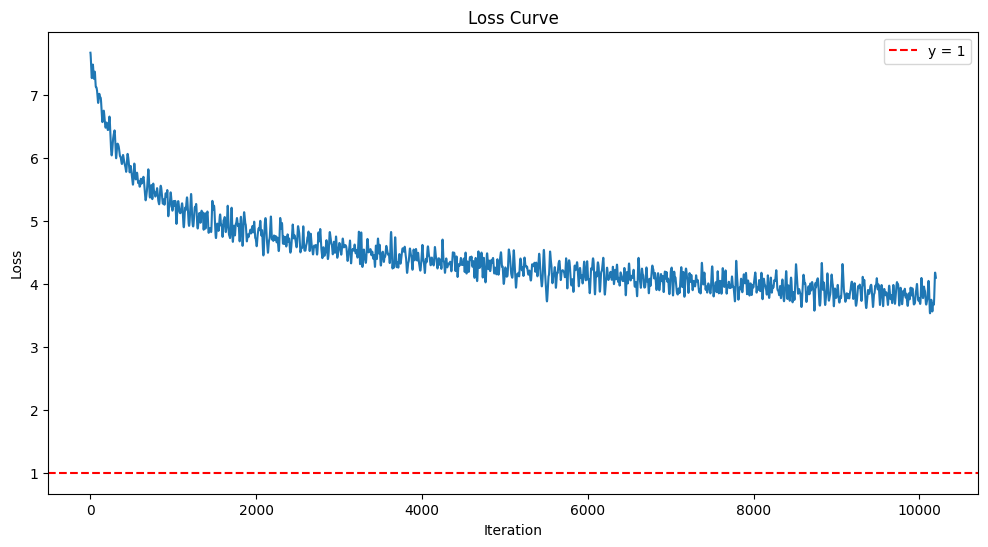

In [ ]:
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from statsmodels.nonparametric.smoothers_lowess import lowess

print(loss_hist[len(loss_hist) - 5:len(loss_hist)])

fig = plt.figure(facecolor="w", figsize=(12, 6))
#plt.plot(np.convolve(loss_hist, np.ones(30)/30, mode='valid'))
#plt.plot(savgol_filter(loss_hist, window_length=100, polyorder=3))
#plt.plot(lowess(loss_hist, np.arange(len(loss_hist)), frac=0.1)[:, 1])
plt.plot(gaussian_filter1d(loss_hist, sigma=6))
#plt.plot(loss_hist)
plt.axhline(y=1, color='r', linestyle='--', label='y = 1')
plt.title("Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
print(val_acc_hist)


[0.2760416666666667, 0.28125, 0.2760416666666667, 0.2604166666666667, 0.2864583333333333, 0.2708333333333333, 0.2760416666666667, 0.2760416666666667, 0.2760416666666667, 0.2708333333333333, 0.2708333333333333, 0.265625, 0.2760416666666667, 0.2708333333333333, 0.2604166666666667, 0.2552083333333333, 0.2760416666666667, 0.2708333333333333, 0.2864583333333333, 0.2760416666666667, 0.2708333333333333, 0.265625, 0.2760416666666667, 0.2708333333333333, 0.2708333333333333, 0.265625, 0.265625, 0.2760416666666667, 0.28125, 0.2864583333333333, 0.28125, 0.2604166666666667, 0.265625, 0.265625, 0.2760416666666667, 0.2708333333333333, 0.2760416666666667, 0.2708333333333333, 0.2916666666666667, 0.265625, 0.2864583333333333, 0.28125, 0.2708333333333333, 0.2760416666666667, 0.2604166666666667, 0.28125, 0.2864583333333333, 0.28125, 0.2864583333333333, 0.2760416666666667, 0.265625, 0.265625, 0.2864583333333333, 0.28125, 0.28125, 0.2708333333333333, 0.28125, 0.265625, 0.2708333333333333, 0.28125, 0.2864583

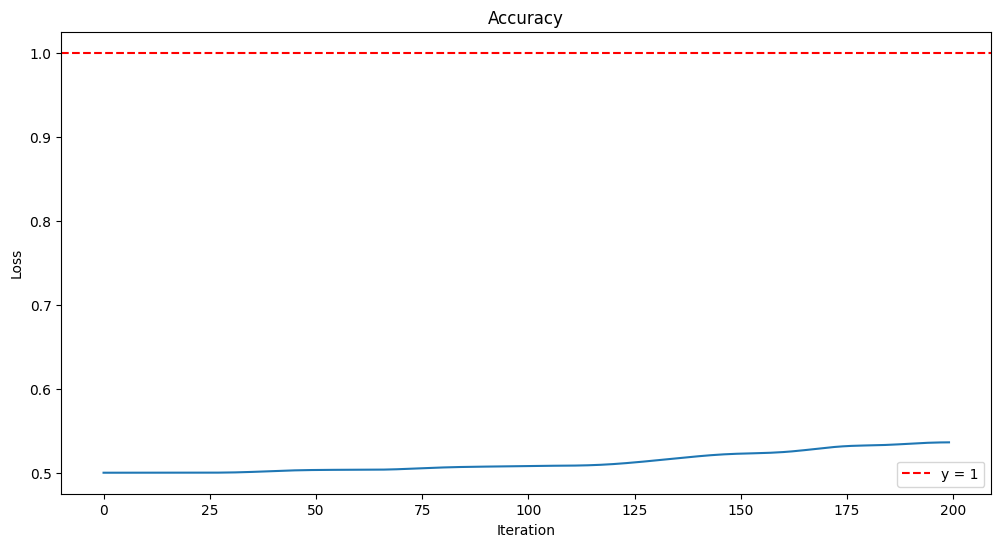

In [ ]:
fig = plt.figure(facecolor="w", figsize=(12, 6))
plt.plot(gaussian_filter1d(val_auc_hist, sigma=6))
plt.axhline(y=1, color='r', linestyle='--', label='y = 1')
plt.title("Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Save Metrics

In [ ]:
metrics_np = np.zeros(12)

for i, metric in enumerate(results):
    metrics_np[i*2] = np.round(np.mean(metric), 3)
    metrics_np[i*2+1] = np.round(np.std(metric), 3)

# Print Results
print(f"Accuracy:  {metrics_np[0]:.3f} ± {metrics_np[1]:.3f}")
print(f"AUC ROC: {metrics_np[2]:.3f} ± {metrics_np[3]:.3f}")
print(f"Sensitivity: {metrics_np[4]:.3f} ± {metrics_np[5]:.3f}")
print(f"Specificity: {metrics_np[6]:.3f} ± {metrics_np[7]:.3f}")

metric_names = ['Acc', 'AUC', 'Sn', 'Sp', 'F1', 'Precision']
metrics_np = metrics_np.reshape(1, -1)
columns = []
for name in metric_names:
    columns.extend([f'Mean {name}', f'Std {name}'])


df_metrics = pd.DataFrame(metrics_np, columns=columns)
dirname = dt_file.strip('.csv')

#adicionar lr
#filename = f"results\\{dirname}\\{target_name}_{fp_type}_{num_bits}_{num_hidden}_{num_steps}_lr{lr}_e{num_epochs}_{loss_type}_{weighted}.csv"
#df_metrics.to_csv(filename, index=False)

#print(filename)

Accuracy:  0.634 ± 0.196
AUC ROC: 0.728 ± 0.106
Sensitivity: 0.552 ± 0.281
Specificity: 0.904 ± 0.082
